In [30]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from energy_py import Runner
from energy_py.agents import DQN
from energy_py.envs import BatteryEnv

In [31]:
#  set random seeds for repeatability
np.random.seed(42)
tf.set_random_seed(42)

In [32]:
#  define a total number of steps for the experiment to run
TOTAL_STEPS = 400000

agent_config = {'discount': 0.97,                 #  the discount rate
                'tau': 0.01,                     #  parameter that controls the copying of weights from online to target network
                'total_steps': TOTAL_STEPS,   
                'batch_size': 32,                 #  size of the minibatches used for learning
                'layers': (50, 50),               #  structure of the neural network used to approximate Q(s,a)
                'learning_rate': 0.01,          #  controls the stength of weight updates during learning       
                'epsilon_decay_fraction': 0.3,    #  a fraction as % of total steps where epsilon decayed from 1.0 to 0.1
                'memory_fraction': 0.4,           #  the size of the replay memory as a % of total steps
                'memory_type': 'deque',           #  the replay memory implementation we want
                'process_observation': 'standardizer',
                'process_target': 'normalizer'}    

#  we just need to let our env know where our state.csv and observation.csv are (data_path)
env = BatteryEnv(data_path=os.getcwd())

In [33]:
#  Runner is a class that helps us with experiments - tracking rewards, writing environment info to csv and managing TensorBoard
#  in this notebook we just use it to track rewards for us
runner = Runner()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #  add the tf session and t-+he environment to the agent config dictionary
    #  and initialize the agent
    agent_config['sess'] = sess
    agent_config['env'] = env
    agent = DQN(**agent_config)
    
    #  initial values for the step and episode number
    step, episode = 0, 0

    #  outer while loop runs through multiple episodes
    while step < TOTAL_STEPS:
        episode += 1
        done = False
        observation = env.reset()
        
        while not done:
            step += 1
            action = agent.act(observation)
            
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience
            agent.remember(observation, action, reward,
                           next_observation, done)
            
            #  moving to the next time step
            observation = next_observation
            #  saving the reward 
            runner.append(reward)
            
            #  we don't start learning until the memory is half full
            if step > int(agent.memory.size * 0.5):  #set threshold to start learning
                train_info = agent.learn()
        
        if episode % 200 == 0:
            print('progress - {:.1f}% - episode {:.0f} - run time {:.2f} - episode reward {:.2f} - avg rewards {:.2f}'.format(100*step/TOTAL_STEPS,
                                                                                                                              episode,
                                                                                                                              runner.calc_time(),
                                                                                                                              sum(runner.ep_rewards),
                                                                                                                              runner.avg_rew))
        #  the report method should be run at the end of each episode
        runner.report({'ep': episode,
                       'step': step})

copying ['hidden_layer_1', 'Variable:0'] to ['hidden_layer_1', 'Variable:0']
copying ['hidden_layer_1', 'Variable_1:0'] to ['hidden_layer_1', 'Variable_1:0']
copying ['input_layer', 'Variable:0'] to ['input_layer', 'Variable:0']
copying ['input_layer', 'Variable_1:0'] to ['input_layer', 'Variable_1:0']
copying ['output_layer', 'Variable:0'] to ['output_layer', 'Variable:0']
copying ['output_layer', 'Variable_1:0'] to ['output_layer', 'Variable_1:0']
copying ['hidden_layer_1', 'Variable:0'] to ['hidden_layer_1', 'Variable:0']
copying ['hidden_layer_1', 'Variable_1:0'] to ['hidden_layer_1', 'Variable_1:0']
copying ['input_layer', 'Variable:0'] to ['input_layer', 'Variable:0']
copying ['input_layer', 'Variable_1:0'] to ['input_layer', 'Variable_1:0']
copying ['output_layer', 'Variable:0'] to ['output_layer', 'Variable:0']
copying ['output_layer', 'Variable_1:0'] to ['output_layer', 'Variable_1:0']
copying ['hidden_layer_1', 'Variable:0'] to ['hidden_layer_1', 'Variable:0']
copying ['hidde

KeyboardInterrupt: 

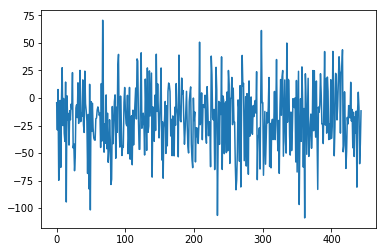

In [34]:
#  plot rewards

import matplotlib.pyplot as plt

episode_rewards = runner.global_rewards
plt.plot(episode_rewards)

In [35]:
#  we can also look at what happened in our last episode
ep_hist = pd.DataFrame.from_dict(info)
fd = pd.DataFrame.from_dict(info)

fd.columns = ['action','done','cpu_utilization','gross_rate','losses','net_stored','new_rate','next_observation','next_state','observation','old_rate','reward','state','steps']
fd =fd.drop('done',1)
#fd.columns = ['action', 'done','cpu_util']
fd.head()
#print(fd['done'],fd['action'])
#ep_hist.head()

,action,cpu_utilization,gross_rate,losses,net_stored,new_rate,next_observation,next_state,observation,old_rate,reward,state,steps
0,"[0.42105263157894735, 1.894736842105263]",50.0,0.000000,0.000000,0.000000,0.000000,"[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]","[[50.0, 0.0]]","[[50.0, 50.0, 50.0, 50.0, 100.0, 0.0, 1.0, 0.0]]",0.000000,-0.000000,"[[50.0, 0.0]]",1
1,"[1.5789473684210527, 0.5263157894736842]",50.0,1.052632,0.008772,0.078947,0.078947,"[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...","[[50.0, 0.07894736842105264]]","[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]",0.000000,-4.385965,"[[50.0, 0.0]]",2
2,"[1.789473684210526, 2.0]",50.0,-0.210526,0.000000,-0.017544,0.061404,"[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...","[[50.0, 0.06140350877192982]]","[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...",0.078947,0.877193,"[[50.0, 0.07894736842105264]]",3
3,"[1.789473684210526, 0.10526315789473684]",50.0,1.684211,0.014035,0.126316,0.187719,"[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...","[[100.0, 0.18771929824561404]]","[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...",0.061404,-7.017544,"[[50.0, 0.06140350877192982]]",4
4,"[0.3157894736842105, 1.894736842105263]",100.0,-1.578947,0.000000,-0.131579,0.056140,"[[100.0, 100.0, 100.0, 100.0, -50.0, 5.0, 1.0,...","[[100.0, 0.05614035087719299]]","[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...",0.187719,13.157895,"[[100.0, 0.18771929824561404]]",5


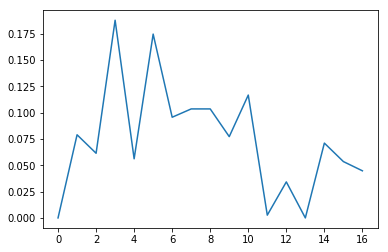

In [36]:
#plt.plot(ep_hist.loc[:, 'new_charge'])
plt.plot(fd.loc[:, 'new_rate'])


Loss function


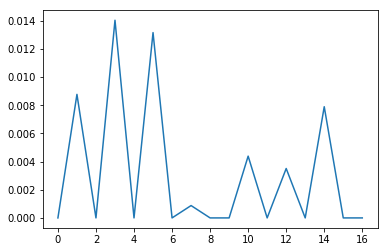

In [37]:
print('Loss function')
plt.plot(fd.loc[:, 'losses'])

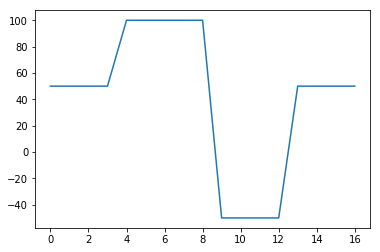

In [38]:
#plt.plot(ep_hist.loc[:, 'electricity_price'])
plt.plot(fd.loc[:, 'cpu_utilization'])

In [21]:
ep_hist.loc[:, 'reward'].sum()

14.342105263157896